In [0]:
!pip install pydrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1OLDT6OhhXrC8FCJkqEreOjfQM_J_9HSg'})
download.GetContentFile('bbdc.zip')

In [0]:
!unzip bbdc.zip

Archive:  bbdc.zip
  inflating: Aufgabenbeschreibung.txt  
  inflating: SensorPlacement.png     
   creating: Subject01/
  inflating: Subject01/Subject01_Aufnahme000.csv  
  inflating: Subject01/Subject01_Aufnahme001.csv  
  inflating: Subject01/Subject01_Aufnahme002.csv  
  inflating: Subject01/Subject01_Aufnahme003.csv  
  inflating: Subject01/Subject01_Aufnahme004.csv  
  inflating: Subject01/Subject01_Aufnahme005.csv  
  inflating: Subject01/Subject01_Aufnahme006.csv  
  inflating: Subject01/Subject01_Aufnahme007.csv  
  inflating: Subject01/Subject01_Aufnahme008.csv  
  inflating: Subject01/Subject01_Aufnahme009.csv  
  inflating: Subject01/Subject01_Aufnahme010.csv  
  inflating: Subject01/Subject01_Aufnahme011.csv  
  inflating: Subject01/Subject01_Aufnahme012.csv  
  inflating: Subject01/Subject01_Aufnahme013.csv  
  inflating: Subject01/Subject01_Aufnahme014.csv  
  inflating: Subject01/Subject01_Aufnahme015.csv  
  inflating: Subject01/Subject01_Aufnahme016.csv  
  inflating:

In [0]:
import csv
import os
import pandas as pd
cwd = os.getcwd()
train_filepath = os.path.join(cwd, "train.csv")


with open(train_filepath, 'rt') as infile:
    with open('new_train.csv', 'wt', newline='') as outfile:
        writer = csv.writer(outfile)
        reader = csv.reader(infile)
        writer.writerow(next(reader))
        for row in reader:
            if row[2] != "lay":
                writer.writerow(row)
    outfile.close()
infile.close()


new_train_filepath = os.path.join(cwd, "new_train.csv")
data = pd.read_csv(new_train_filepath)

In [0]:
train_part=data[:4814]
valid_part=data[4814:]

In [0]:
class_translate = {"run":0, "walk":1, "stand":2, "sit":3, "sit-to-stand":4, "stand-to-sit":5,\
                 "stair-up":6, "stair-down":7, "jump-one-leg":8, "jump-two-leg":9, "curve-left-step":10,\
                   "curve-right-step":11, "curve-left-spin-Lfirst":12, "curve-left-spin-Rfirst":13, "curve-right-spin-Lfirst":14,\
                   "curve-right-spin-Rfirst":15, "lateral-shuffle-left":16, "lateral-shuffle-right":17,"v-cut-left-Lfirst":18,\
                   "v-cut-left-Rfirst":19, "v-cut-right-Lfirst":20, "v-cut-right-Rfirst":21}

names = ["EMG1", "EMG2","EMG3","EMG4","Airborne","ACC upper X","ACC upper Y", \
         "ACC upper Z","Goniometer X","ACC lower X","ACC lower Y","ACC loewr Z",\
         "Goniometer Y","Gyro upper X","Gyro upper Y","Gyro upper Z","Gyro lower X",\
         "Gyro lower Y","Gyro lower Z","ACC upper mag", "ACC lower mag", "Goniometer mag",\
         "Gyro upper mag","Gyro lower mag", "ACC ul X", "ACC ul Y", "ACC ul Z", "Gyro ul X", "Gyro ul Y", "Gyrp ul Z"]


In [0]:
!pip install tsfresh

    100% |████████████████████████████████| 122kB 4.6MB/s 


In [0]:
from tsfresh.feature_extraction.feature_calculators import abs_energy, absolute_sum_of_changes, cid_ce,\
approximate_entropy,augmented_dickey_fuller,autocorrelation,c3,count_above_mean, count_below_mean,mean_abs_change,\
mean_change,mean_second_derivative_central,number_cwt_peaks, partial_autocorrelation, ratio_beyond_r_sigma,time_reversal_asymmetry_statistic

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random


In [0]:
cols = [s+"_mean" for s in names]+[s+"_std" for s in names]+[s+"_mad" for s in names]+[s+"_max" for s in names]+\
[s+"_min" for s in names]+[s+"_skew" for s in names]+[s+"_kurt" for s in names]+\
[s+"_iqr" for s in names]+[s+"_asoc" for s in names]+[s+"_cidce" for s in names]+\
[s+"_c3" for s in names]+\
[s+"_mac" for s in names]+\
[s+"_rbrs" for s in names]+[s+"_tras" for s in names]

In [0]:
names = ["EMG1", "EMG2","EMG3","EMG4","Airborne","ACC upper X","ACC upper Y", \
         "ACC upper Z","Goniometer X","ACC lower X","ACC lower Y","ACC loewr Z",\
         "Goniometer Y","Gyro upper X","Gyro upper Y","Gyro upper Z","Gyro lower X",\
         "Gyro lower Y","Gyro lower Z","ACC upper mag", "ACC lower mag", "Goniometer mag",\
         "Gyro upper mag","Gyro lower mag", "ACC ul X", "ACC ul Y", "ACC ul Z", "Gyro ul X", "Gyro ul Y", "Gyrp ul Z"]


lst_train = []
lst_train_y=[]

for j in range(len(train_part)):
  dat = pd.read_csv(os.path.join(cwd,train_part.iat[j,1]), header=None)
  dat[19]=(dat[5]**2+dat[6]**2+dat[7]**2)**0.5 #ACC upper mag
  dat[20]=(dat[9]**2+dat[10]**2+dat[11]**2)**0.5 #ACC lower mag
  dat[21]=(dat[8]**2+dat[12]**2)**0.5 # Goniometer mag
  dat[22]=(dat[13]**2+dat[14]**2+dat[15]**2)**0.5 #Gyro upper mag
  dat[23]=(dat[16]**2+dat[17]**2+dat[18]**2)**0.5 # Gyro lower mag
  dat[24]=(dat[5]/dat[9]) # Acc ul X
  dat[25]=(dat[6]/dat[10]) # Acc ul Y
  dat[26]=(dat[7]/dat[11]) # Acc ul Z
  dat[27]=(dat[13]/dat[16]) # gyro ul X
  dat[28]=(dat[14]/dat[17]) # gyro ul y
  dat[29]=(dat[15]/dat[18])# gyro ul z
  #angle acc
  #dat[24]=[angle_between((dat.iloc[i,5],dat.iloc[i,6],dat.iloc[i,7]),(dat.iloc[i,9],dat.iloc[i,10],dat.iloc[i,11])) for i in range(len(dat))]
  #angle gyro
  #dat[25]=[angle_between((dat.iloc[i,13],dat.iloc[i,14],dat.iloc[i,15]),(dat.iloc[i,16],dat.iloc[i,17],dat.iloc[i,18])) for i in range(len(dat))]
  #dat[24]=(dat[22]/dat[23]) # Gyro mag ratio
  #dat[25]=(dat[19]/dat[20]) # ACC mag ratio
  
  
  
  
  meanV= dat.mean(axis=0).tolist()
  stdV = dat.std(axis=0).tolist()
  madV = dat.mad(axis=0).tolist()
  maxV = dat.max(axis=0).tolist()
  minV = dat.min(axis=0).tolist()
  skewV = dat.skew(axis=0).tolist()
  kurtV = dat.kurt(axis=0).tolist()
  #energyV = [abs_energy(dat.values[:,i])/len(dat) for i in range(24)]
  iqrV = (dat.quantile(0.75,axis=0)-dat.quantile(0.25,axis=0)).tolist()
  
  asocV = [absolute_sum_of_changes(dat.values[:,i]) for i in range(30)]
  cidceV = [cid_ce(dat.values[:,i], True) for i in range(30)]
  #aentropyV = [approximate_entropy(dat.values[:,i], 2, 1.0) for i in range(26)]
  #adfV=[augmented_dickey_fuller(dat.values[:,i],[{"attr":"usedlag"}]) for i in range(26)]
  #acV=[autocorrelation(dat.values[:,i],100) for i in range(24)]
  c3V=[c3(dat.values[:,i],100) for i in range(30)]
  #camV=[count_above_mean(dat.values[:,i]) for i in range(24)]
  #cbmV=[count_below_mean(dat.values[:,i]) for i in range(24)]
  
  #dftV=[max(np.fft.rfft(dat.values[:,i]).real) for i in range(26)]
  macV=[mean_abs_change(dat.values[:,i]) for i in range(30)]
  #mcV=[mean_change(dat.values[:,i]) for i in range(26)]
  #msdcV=[mean_second_derivative_central(dat.values[:,i]) for i in range(24)]
  #ncwtV=[number_cwt_peaks(dat.values[:,i], 500) for i in range(26)]
  #pacV=[partial_autocorrelation(dat.values[:,i], [{"lag": 100}]) for i in range(26)]
  rbrsV=[ratio_beyond_r_sigma(dat.values[:,i], 2) for i in range(30)]
  trasV=[time_reversal_asymmetry_statistic(dat.values[:,i], 100) for i in range(30)]
  lst_train.append(meanV+stdV+madV+maxV+minV+skewV+kurtV+iqrV+asocV+cidceV+c3V+macV+\
                   rbrsV+trasV)
  
  #lst_train.append(meanV+stdV+madV+maxV+minV+skewV+kurtV+iqrV)
  lst_train_y.append(train_part.iat[j,2])
  

  print("Row:", j)




Row: 0
Row: 1
Row: 2
Row: 3
Row: 4
Row: 5
Row: 6
Row: 7
Row: 8
Row: 9
Row: 10
Row: 11
Row: 12
Row: 13
Row: 14
Row: 15
Row: 16
Row: 17
Row: 18
Row: 19
Row: 20
Row: 21
Row: 22
Row: 23
Row: 24
Row: 25
Row: 26
Row: 27
Row: 28
Row: 29
Row: 30
Row: 31
Row: 32
Row: 33
Row: 34
Row: 35
Row: 36
Row: 37
Row: 38
Row: 39
Row: 40
Row: 41
Row: 42
Row: 43
Row: 44
Row: 45
Row: 46
Row: 47
Row: 48
Row: 49
Row: 50
Row: 51
Row: 52
Row: 53
Row: 54
Row: 55
Row: 56
Row: 57
Row: 58
Row: 59
Row: 60
Row: 61
Row: 62
Row: 63
Row: 64
Row: 65
Row: 66
Row: 67
Row: 68
Row: 69
Row: 70
Row: 71
Row: 72
Row: 73
Row: 74
Row: 75
Row: 76
Row: 77
Row: 78
Row: 79
Row: 80
Row: 81
Row: 82
Row: 83
Row: 84
Row: 85
Row: 86
Row: 87
Row: 88
Row: 89
Row: 90
Row: 91
Row: 92
Row: 93
Row: 94
Row: 95
Row: 96
Row: 97
Row: 98
Row: 99
Row: 100
Row: 101
Row: 102
Row: 103
Row: 104
Row: 105
Row: 106
Row: 107
Row: 108
Row: 109
Row: 110
Row: 111
Row: 112
Row: 113
Row: 114
Row: 115
Row: 116
Row: 117
Row: 118
Row: 119
Row: 120
Row: 121
Row: 122
Row

In [0]:
df_train = pd.DataFrame(lst_train, columns=cols)
df_train.to_csv("Train.csv", encoding='utf-8', index=False)
df_train_y = pd.DataFrame(lst_train_y, columns=["Label"])
df_train_y.to_csv("Train_y.csv", encoding='utf-8', index=False)

In [0]:

lst_test = []
lst_test_y=[]
for j in range(len(valid_part)):
  dat = pd.read_csv(os.path.join(cwd,valid_part.iat[j,1]), header=None)
  dat[19]=(dat[5]**2+dat[6]**2+dat[7]**2)**0.5 #ACC upper mag
  dat[20]=(dat[9]**2+dat[10]**2+dat[11]**2)**0.5 #ACC lower mag
  dat[21]=(dat[8]**2+dat[12]**2)**0.5 # Goniometer mag
  dat[22]=(dat[13]**2+dat[14]**2+dat[15]**2)**0.5 #Gyro upper mag
  dat[23]=(dat[16]**2+dat[17]**2+dat[18]**2)**0.5 # Gyro lower mag
  dat[24]=(dat[5]/dat[9]) # Acc ul X
  dat[25]=(dat[6]/dat[10]) # Acc ul Y
  dat[26]=(dat[7]/dat[11]) # Acc ul Z
  dat[27]=(dat[13]/dat[16]) # gyro ul X
  dat[28]=(dat[14]/dat[17]) # gyro ul y
  dat[29]=(dat[15]/dat[18])# gyro ul z
  #angle acc
  #dat[24]=[angle_between((dat.iloc[i,5],dat.iloc[i,6],dat.iloc[i,7]),(dat.iloc[i,9],dat.iloc[i,10],dat.iloc[i,11])) for i in range(len(dat))]
  #angle gyro
  #dat[25]=[angle_between((dat.iloc[i,13],dat.iloc[i,14],dat.iloc[i,15]),(dat.iloc[i,16],dat.iloc[i,17],dat.iloc[i,18])) for i in range(len(dat))]
  #dat[24]=(dat[22]/dat[23]) # Gyro mag ratio
  #dat[25]=(dat[19]/dat[20]) # ACC mag ratio
  
  #dat[24]=(dat[22]/dat[23]) # Gyro mag ratio
  #dat[25]=(dat[19]/dat[20]) # ACC mag ratio
  
  
  
 
  
  meanV= dat.mean(axis=0).tolist()
  stdV = dat.std(axis=0).tolist()
  madV = dat.mad(axis=0).tolist()
  maxV = dat.max(axis=0).tolist()
  minV = dat.min(axis=0).tolist()
  skewV = dat.skew(axis=0).tolist()
  kurtV = dat.kurt(axis=0).tolist()
  #energyV = [abs_energy(dat.values[:,i])/len(dat) for i in range(24)]
  iqrV = (dat.quantile(0.75,axis=0)-dat.quantile(0.25,axis=0)).tolist()
  
  asocV = [absolute_sum_of_changes(dat.values[:,i]) for i in range(30)]
  cidceV = [cid_ce(dat.values[:,i], True) for i in range(30)]
  #aentropyV = [approximate_entropy(dat.values[:,i], 2, 1.0) for i in range(26)]
  #adfV=[augmented_dickey_fuller(dat.values[:,i],[{"attr":"usedlag"}]) for i in range(26)]
  #acV=[autocorrelation(dat.values[:,i],100) for i in range(24)]
  c3V=[c3(dat.values[:,i],100) for i in range(30)]
  #camV=[count_above_mean(dat.values[:,i]) for i in range(24)]
  #cbmV=[count_below_mean(dat.values[:,i]) for i in range(24)]
  
  #dftV=[max(np.fft.rfft(dat.values[:,i]).real) for i in range(26)]
  macV=[mean_abs_change(dat.values[:,i]) for i in range(30)]
  #mcV=[mean_change(dat.values[:,i]) for i in range(26)]
  #msdcV=[mean_second_derivative_central(dat.values[:,i]) for i in range(24)]
  #ncwtV=[number_cwt_peaks(dat.values[:,i], 500) for i in range(26)]
  #pacV=[partial_autocorrelation(dat.values[:,i], [{"lag": 100}]) for i in range(26)]
  rbrsV=[ratio_beyond_r_sigma(dat.values[:,i], 2) for i in range(30)]
  trasV=[time_reversal_asymmetry_statistic(dat.values[:,i], 100) for i in range(30)]
  lst_test.append(meanV+stdV+madV+maxV+minV+skewV+kurtV+iqrV+asocV+cidceV+c3V+macV+\
                   rbrsV+trasV)
  
  #lst_train.append(meanV+stdV+madV+maxV+minV+skewV+kurtV+iqrV)
  lst_test_y.append(valid_part.iat[j,2])
  

  print("Row:", j)

df_test = pd.DataFrame(lst_test, columns=cols)
df_test.to_csv("Test.csv", encoding='utf-8', index=False)
df_test_y = pd.DataFrame(lst_test_y, columns=["Label"])
df_test_y.to_csv("Test_y.csv", encoding='utf-8', index=False)

Row: 0
Row: 1
Row: 2
Row: 3
Row: 4
Row: 5
Row: 6
Row: 7
Row: 8
Row: 9
Row: 10
Row: 11
Row: 12
Row: 13
Row: 14
Row: 15
Row: 16
Row: 17
Row: 18
Row: 19
Row: 20
Row: 21
Row: 22
Row: 23
Row: 24
Row: 25
Row: 26
Row: 27
Row: 28
Row: 29
Row: 30
Row: 31
Row: 32
Row: 33
Row: 34
Row: 35
Row: 36
Row: 37
Row: 38
Row: 39
Row: 40
Row: 41
Row: 42
Row: 43
Row: 44
Row: 45
Row: 46
Row: 47
Row: 48
Row: 49
Row: 50
Row: 51
Row: 52
Row: 53
Row: 54
Row: 55
Row: 56
Row: 57
Row: 58
Row: 59
Row: 60
Row: 61
Row: 62
Row: 63
Row: 64
Row: 65
Row: 66
Row: 67
Row: 68
Row: 69
Row: 70
Row: 71
Row: 72
Row: 73
Row: 74
Row: 75
Row: 76
Row: 77
Row: 78
Row: 79
Row: 80
Row: 81
Row: 82
Row: 83
Row: 84
Row: 85
Row: 86
Row: 87
Row: 88
Row: 89
Row: 90
Row: 91
Row: 92
Row: 93
Row: 94
Row: 95
Row: 96
Row: 97
Row: 98
Row: 99
Row: 100
Row: 101
Row: 102
Row: 103
Row: 104
Row: 105
Row: 106
Row: 107
Row: 108
Row: 109
Row: 110
Row: 111
Row: 112
Row: 113
Row: 114
Row: 115
Row: 116
Row: 117
Row: 118
Row: 119
Row: 120
Row: 121
Row: 122
Row

In [0]:
X_train = pd.read_csv("Train.csv")
feats = [f for f in X_train.columns]

x_test = pd.read_csv("Test.csv")

#x_test = x_test.values
##Y_train = data["Label"]
Y_train = pd.read_csv("Train_y.csv")

y_test = pd.read_csv("Test_y.csv")
#Y_train=[class_translate[train.iat[j,2]] for j in range(len(train))]
#y_test=[class_translate[test.iat[j,2]] for j in range(len(test))]


#import random
#kfold = KFold(n_splits=5, shuffle=True, random_state=7)
#feature_importance_df = pd.DataFrame()
#x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,test_size=0.3, random_state=random.randint(0,1000), stratify=Y_train)
#x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,test_size=0.3, random_state=random.randint(0,1000))

In [0]:
X_merged= pd.concat([X_train, x_test])

In [0]:
Y_train = [class_translate[Y_train.iat[j,0]] for j in range(len(Y_train))]
y_test = [class_translate[y_test.iat[j,0]] for j in range(len(y_test))]

In [0]:
Y_merged=Y_train+ y_test

In [0]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(15,45))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [0]:
feature_importance_df = pd.DataFrame()

In [0]:
clf10 = LGBMClassifier(
            nthreads=3,
            n_estimators=1200,
            objective= "multiclass",
            num_class = 22,
            boosting_type= "gbdt",
            #drop_rate=0.4,
            metric= 'multi_error',
            learning_rate=0.05,
            num_leaves=20, ## 30, 6
            min_data_in_leaf = 200,
            colsample_bytree=.85,
            bagging_fraction=0.6,
            scale_pos_weight=1,
            subsample=.1,
            subsample_for_bin=2000,
            subsample_freq=2,
            max_depth=7,
            max_bin=20,
            reg_alpha=2.7,
            reg_lambda=2.6,
            min_split_gain=.5,
            min_child_sample=220,
            min_child_weight=2,
            silent=-1,
            verbose=10)
clf10.fit(X_train,Y_train, eval_set= [(X_train,Y_train),(x_test, y_test)], verbose= 100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_error: 0.0201496	valid_1's multi_error: 0.332272
[200]	training's multi_error: 0.0083091	valid_1's multi_error: 0.305538
[300]	training's multi_error: 0.00747819	valid_1's multi_error: 0.301082
Early stopping, best iteration is:
[251]	training's multi_error: 0.00789364	valid_1's multi_error: 0.300446


LGBMClassifier(bagging_fraction=0.6, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.85, importance_type='split', learning_rate=0.05,
        max_bin=20, max_depth=7, metric='multi_error',
        min_child_sample=220, min_child_samples=20, min_child_weight=2,
        min_data_in_leaf=200, min_split_gain=0.5, n_estimators=1200,
        n_jobs=-1, nthreads=3, num_class=22, num_leaves=20,
        objective='multiclass', random_state=None, reg_alpha=2.7,
        reg_lambda=2.6, scale_pos_weight=1, silent=-1, subsample=0.1,
        subsample_for_bin=2000, subsample_freq=2, verbose=10)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


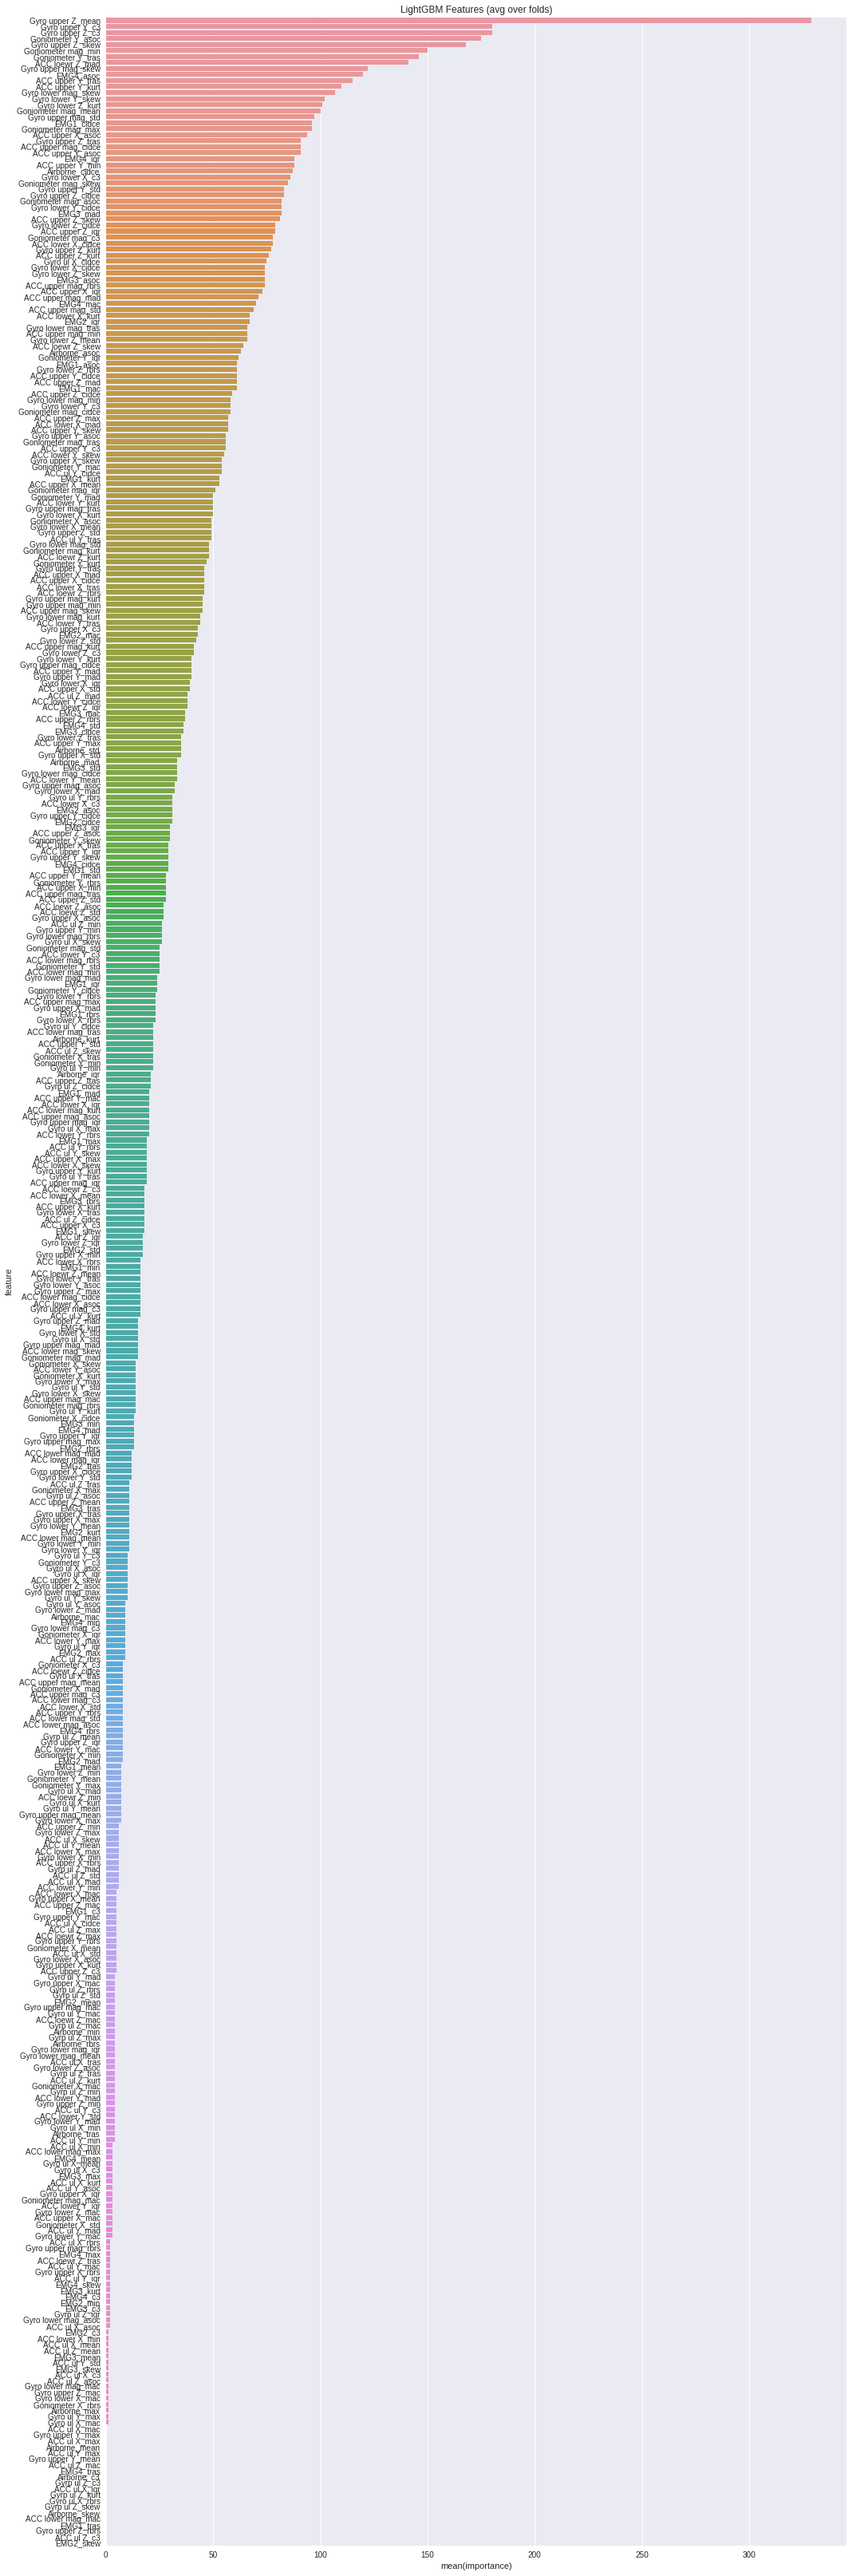

In [0]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf10.feature_importances_
# #fold_importance_df["fold"] = n_fold + 1
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

display_importances(feature_importance_df)

In [0]:
clf11 = LGBMClassifier(
            nthreads=3,
            n_estimators=300,
            objective= "multiclass",
            num_class = 22,
            boosting_type= "gbdt",
            #drop_rate=0.4,
            metric= 'multi_error',
            learning_rate=0.05,
            num_leaves=20, ## 30, 6
            min_data_in_leaf = 200,
            colsample_bytree=.85,
            bagging_fraction=0.6,
            scale_pos_weight=1,
            subsample=.1,
            subsample_for_bin=2000,
            subsample_freq=2,
            max_depth=7,
            max_bin=20,
            reg_alpha=2.7,
            reg_lambda=2.6,
            min_split_gain=.5,
            min_child_sample=220,
            min_child_weight=2,
            silent=-1,
            verbose=10)
clf11.fit(X_merged,Y_merged, verbose= 100)

LGBMClassifier(bagging_fraction=0.6, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.85, importance_type='split', learning_rate=0.05,
        max_bin=20, max_depth=7, metric='multi_error',
        min_child_sample=220, min_child_samples=20, min_child_weight=2,
        min_data_in_leaf=200, min_split_gain=0.5, n_estimators=300,
        n_jobs=-1, nthreads=3, num_class=22, num_leaves=20,
        objective='multiclass', random_state=None, reg_alpha=2.7,
        reg_lambda=2.6, scale_pos_weight=1, silent=-1, subsample=0.1,
        subsample_for_bin=2000, subsample_freq=2, verbose=10)

In [0]:
class_reverse = {0:"run", 1:"walk", 2:"stand", 3:"sit", 4:"sit-to-stand", 5:"stand-to-sit",\
                 6:"stair-up", 7:"stair-down", 8:"jump-one-leg", 9:"jump-two-leg", 10:"curve-left-step",\
                   11:"curve-right-step", 12:"curve-left-spin-Lfirst", 13:"curve-left-spin-Rfirst", 14:"curve-right-spin-Lfirst",\
                   15:"curve-right-spin-Rfirst", 16:"lateral-shuffle-left", 17:"lateral-shuffle-right",18:"v-cut-left-Lfirst",\
                   19:"v-cut-left-Rfirst", 20:"v-cut-right-Lfirst", 21:"v-cut-right-Rfirst"}


In [0]:
cha = pd.read_csv("challenge.csv")
lst_cha = []
#lst_test_y=[]
for j in range(len(cha)):
  dat = pd.read_csv(os.path.join(cwd,cha.iat[j,1]), header=None)
  dat[19]=(dat[5]**2+dat[6]**2+dat[7]**2)**0.5 #ACC upper mag
  dat[20]=(dat[9]**2+dat[10]**2+dat[11]**2)**0.5 #ACC lower mag
  dat[21]=(dat[8]**2+dat[12]**2)**0.5 # Goniometer mag
  dat[22]=(dat[13]**2+dat[14]**2+dat[15]**2)**0.5 #Gyro upper mag
  dat[23]=(dat[16]**2+dat[17]**2+dat[18]**2)**0.5 # Gyro lower mag
  dat[24]=(dat[5]/dat[9]) # Acc ul X
  dat[25]=(dat[6]/dat[10]) # Acc ul Y
  dat[26]=(dat[7]/dat[11]) # Acc ul Z
  dat[27]=(dat[13]/dat[16]) # gyro ul X
  dat[28]=(dat[14]/dat[17]) # gyro ul y
  dat[29]=(dat[15]/dat[18])# gyro ul z
  #dat[24]=(dat[22]/dat[23]) # Gyro mag ratio
  #dat[25]=(dat[19]/dat[20]) # ACC mag ratio
  #angle acc
  #dat[24]=[angle_between((dat.iloc[i,5],dat.iloc[i,6],dat.iloc[i,7]),(dat.iloc[i,9],dat.iloc[i,10],dat.iloc[i,11])) for i in range(len(dat))]
  #angle gyro
  #dat[25]=[angle_between((dat.iloc[i,13],dat.iloc[i,14],dat.iloc[i,15]),(dat.iloc[i,16],dat.iloc[i,17],dat.iloc[i,18])) for i in range(len(dat))]
  meanV= dat.mean(axis=0).tolist()
  stdV = dat.std(axis=0).tolist()
  madV = dat.mad(axis=0).tolist()
  maxV = dat.max(axis=0).tolist()
  minV = dat.min(axis=0).tolist()
  skewV = dat.skew(axis=0).tolist()
  kurtV = dat.kurt(axis=0).tolist()
  #energyV = [abs_energy(dat.values[:,i])/len(dat) for i in range(24)]
  iqrV = (dat.quantile(0.75,axis=0)-dat.quantile(0.25,axis=0)).tolist()
  
  asocV = [absolute_sum_of_changes(dat.values[:,i]) for i in range(30)]
  cidceV = [cid_ce(dat.values[:,i], True) for i in range(30)]
  #aentropyV = [approximate_entropy(dat.values[:,i], 2, 1.0) for i in range(26)]
  #adfV=[augmented_dickey_fuller(dat.values[:,i],[{"attr":"usedlag"}]) for i in range(26)]
  #acV=[autocorrelation(dat.values[:,i],100) for i in range(24)]
  c3V=[c3(dat.values[:,i],100) for i in range(30)]
  #camV=[count_above_mean(dat.values[:,i]) for i in range(24)]
  #cbmV=[count_below_mean(dat.values[:,i]) for i in range(24)]
  
  #dftV=[max(np.fft.rfft(dat.values[:,i]).real) for i in range(26)]
  macV=[mean_abs_change(dat.values[:,i]) for i in range(30)]
  #mcV=[mean_change(dat.values[:,i]) for i in range(26)]
  #msdcV=[mean_second_derivative_central(dat.values[:,i]) for i in range(24)]
  #ncwtV=[number_cwt_peaks(dat.values[:,i], 500) for i in range(26)]
  #pacV=[partial_autocorrelation(dat.values[:,i], [{"lag": 100}]) for i in range(26)]
  rbrsV=[ratio_beyond_r_sigma(dat.values[:,i], 2) for i in range(30)]
  trasV=[time_reversal_asymmetry_statistic(dat.values[:,i], 100) for i in range(30)]
  lst_cha.append(meanV+stdV+madV+maxV+minV+skewV+kurtV+iqrV+asocV+cidceV+c3V+macV+\
                   rbrsV+trasV)
  #lst_test_y.append(test.iat[j,2])
  print("Row:", j)


Row: 0
Row: 1
Row: 2
Row: 3
Row: 4
Row: 5
Row: 6
Row: 7
Row: 8
Row: 9
Row: 10
Row: 11
Row: 12
Row: 13
Row: 14
Row: 15
Row: 16
Row: 17
Row: 18
Row: 19
Row: 20
Row: 21
Row: 22
Row: 23
Row: 24
Row: 25
Row: 26
Row: 27
Row: 28
Row: 29
Row: 30
Row: 31
Row: 32
Row: 33
Row: 34
Row: 35
Row: 36
Row: 37
Row: 38
Row: 39
Row: 40
Row: 41
Row: 42
Row: 43
Row: 44
Row: 45
Row: 46
Row: 47
Row: 48
Row: 49
Row: 50
Row: 51
Row: 52
Row: 53
Row: 54
Row: 55
Row: 56
Row: 57
Row: 58
Row: 59
Row: 60
Row: 61
Row: 62
Row: 63
Row: 64
Row: 65
Row: 66
Row: 67
Row: 68
Row: 69
Row: 70
Row: 71
Row: 72
Row: 73
Row: 74
Row: 75
Row: 76
Row: 77
Row: 78
Row: 79
Row: 80
Row: 81
Row: 82
Row: 83
Row: 84
Row: 85
Row: 86
Row: 87
Row: 88
Row: 89
Row: 90
Row: 91
Row: 92
Row: 93
Row: 94
Row: 95
Row: 96
Row: 97
Row: 98
Row: 99
Row: 100
Row: 101
Row: 102
Row: 103
Row: 104
Row: 105
Row: 106
Row: 107
Row: 108
Row: 109
Row: 110
Row: 111
Row: 112
Row: 113
Row: 114
Row: 115
Row: 116
Row: 117
Row: 118
Row: 119
Row: 120
Row: 121
Row: 122
Row

In [0]:
df_cha = pd.DataFrame(lst_cha, columns=cols)
df_cha.to_csv("cha.csv", encoding='utf-8', index=False)
#df_test_y = pd.DataFrame(lst_test_y, columns=["Label"])
#df_test_y.to_csv("Test_y.csv", encoding='utf-8', index=False)

96.0


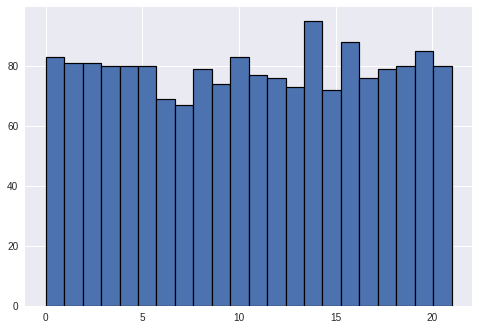

In [0]:
cha_pred = clf11.predict(df_cha)
count = np.zeros(22)
for i in cha_pred:
  count[i]+=1
error=0
for i in count:
  error+=abs(i-79)
print(error)
plt.hist(cha_pred, edgecolor='black', linewidth=1.2, bins=22)
plt.show()

In [0]:
cha_pred_f = [class_reverse[x] for x in cha_pred]
cha_pred_f
to_submit = pd.read_csv("challenge.csv")
to_submit['Label'] = pd.Series(cha_pred_f, index=to_submit.index)
to_submit.to_csv("challenge_submit17.csv", encoding='utf-8', index=False)